In [2]:
# DataLoaders

import torch
import os
from scipy.io import loadmat
import numpy as np
from py2d.initialize import initialize_wavenumbers_rfft2
from py2d.convert import Omega2Psi, Psi2UV


def get_dataloader(data_dir, file_range, batch_size, train, num_workers=1, pin_memory=True):

    dataset = TurbulenceDataset(data_dir=data_dir, file_range=file_range)

    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             shuffle=train,
                                             num_workers=num_workers,
                                             pin_memory=pin_memory)

    return dataloader, dataset


class TurbulenceDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, file_range, target_steps=1):
        """
        Args:
            data_dir (str): Directory with .mat data files.
            file_range (tuple): Range of file numbers (start, end).
        """
        self.data_dir = data_dir
        self.file_numbers = range(file_range[0], file_range[1] + 1)
        self.file_list = [os.path.join(data_dir, f"{i}.mat") for i in self.file_numbers]
        self.target_steps= target_steps

    def __len__(self):
        return len(self.file_list) - self.target_steps

    def __getitem__(self, idx):
        """
        Args:
          idx (int): Index of the file to load.

        Returns:
          tuple (torch.Tensor): Data loaded from the .mat file.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        input_file_path = self.file_list[idx]
        label_file_path = self.file_list[idx+self.target_steps]

        input_mat_data = loadmat(input_file_path)
        label_mat_data = loadmat(label_file_path)

        input_Omega = input_mat_data['Omega']
        label_Omega = label_mat_data['Omega']

        input_data_tensor = self.omega2uv(input_Omega).unsqueeze(1)
        label_data_tensor = self.omega2uv(label_Omega).unsqueeze(1)

        data_tensor = (input_data_tensor, label_data_tensor)

        return data_tensor

    def omega2uv(self, Omega):
        """
        Args:
          Omega (np.array): 2D Omega data.
        Returns:
          data_tensor (torch.Tensor): U, V data.
        """
        nx, ny = Omega.shape
        Lx, Ly = 2 * np.pi, 2 * np.pi
        Kx, Ky, _, _, invKsq = initialize_wavenumbers_rfft2(nx, ny, Lx, Ly, INDEXING='ij')

        Psi = Omega2Psi(Omega, invKsq)
        U, V = Psi2UV(Psi, Kx, Ky)

        # Combine U and V into a single tensor with 2 channels
        data_tensor = torch.tensor(np.stack([U, V]), dtype=torch.float32)

        return data_tensor

/jet/home/dpatel9/.conda/envs/2DTurbEmulator/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import torch
import os
import sys
import pickle
from torch import nn

sys.path.append('/jet/home/dpatel9/SSL-Wavelets/src')
from src.models.vision_transformer import ViT

In [5]:
params = {
    "gpu": True,
    "lr" : 2e-4,
    "weight_decay" : 1e-2,
    "max_epochs" : 5,
    "data_dir" : '/ocean/projects/phy220045p/jakhar/py2d_dealias/results/Re5000_fkx4fky4_r0.1_b20.0/NoSGS/NX256/dt0.0002_IC1/data/',
    "train_file_range" : (200000, 220000),
    "valid_file_range" : (310000, 312000),
    "batch_size" : 64,
    "num_workers" : 1,
    "pin_memory" : True,
    "img_size" : 256,
    "patch_size" : 16,
    "num_frames" : 1,
    "tubelet_size" : 1,
    "in_chans" : 2,
    "encoder_embed_dim" : 192,
    "encoder_depth" : 12,
    "encoder_num_heads" : 6,
    "decoder_embed_dim" : 192,
    "decoder_depth" : 12,
    "decoder_num_heads" : 6,
    "mlp_ratio" : 4.,
    "norm_layer" : nn.LayerNorm,
    "num_out_frames" : 1,
    "log_to_screen" : True,
    "logfile_path": '/ocean/projects/atm170004p/dpatel9/Logfiles/test.log',
    "save_model": True,
    "model_save_dir": '/ocean/projects/atm170004p/dpatel9/ML_Weights/Base_Emulator/',
    "model_save_name": 'test.pt',
    "params_save_name": 'test_parameters.pkl'
}

In [ ]:
# Load model and parameters
root_dir = '/ocean/projects/atm170004p/dpatel9/ML_Weights/Base_Emulator/'
model_filename = 'test1.pt'
params_filename = 'test1_parameters.pkl'

# Read in parameter file as a python dictionary
params_fp = os.path.join(root_dir, params_filename)
with open(params_fp, 'rb') as f:
    params = pickle.load(f)

# Load model
model_fp = os.path.join(root_dir, model_filename)

model = ViT(
    img_size=params["img_size"],
    patch_size=params["patch_size"],
    num_frames=params["num_frames"],
    tubelet_size=params["tubelet_size"],
    in_chans=params["in_chans"],
    encoder_embed_dim=params["encoder_embed_dim"],
    encoder_depth=params["encoder_depth"],
    encoder_num_heads=params["encoder_num_heads"],
    decoder_embed_dim=params["decoder_embed_dim"],
    decoder_depth=params["decoder_depth"],
    decoder_num_heads=params["decoder_num_heads"],
    mlp_ratio=params["mlp_ratio"],
    norm_layer=params["norm_layer"],
    num_out_frames=params["num_out_frames"]
)
model.load_state_dict(torch.load(model_fp, map_location=torch.device('cpu')))
model.eval()

In [14]:
# Get test data

test_file_range = (350000, 350018)
test_length = 6
dataloader, dataset = get_dataloader(data_dir=params["data_dir"],
                                    file_range=test_file_range,
                                    batch_size=test_length,
                                    train=False,
                                    num_workers=params["num_workers"],
                                    pin_memory=params["pin_memory"])

In [15]:
# A single n-step prediction and rmse

def n_step_prediction(model, ic, n=1):
    """Produce an n-step forward roll-out 
    prediction.
    Args:
        model: trained pytorch model.
        ic: initial condition for prediction.
        n (int): nnumber of steps to predict for.
    Returns:
        pred: n-step model prediction (time along dim=0)."""
    
    pred = [ic]
    with torch.no_grad():
        for i in range(n):
            pred.append(model(pred[-1]))
    
    pred = torch.cat(pred, dim=0)

    return pred


def get_rmse(target, pred, dims_to_reduce=None):
    err = (target - pred) ** 2
    err = err.mean(dim=dims_to_reduce)
    rmse = torch.sqrt(err)
    return rmse

In [16]:
# Test predictive skill

rmse = []
rmse_per = []

for i, batch in enumerate(dataloader):

    inputs, target = batch
    ic = inputs[0].unsqueeze(dim=0)
    n_steps = inputs.shape[0]
    print(f"n_steps: {n_steps}")

    pred = n_step_prediction(model, ic, n_steps)
    pred = pred[1:]
    per_pred = inputs[0].repeat(n_steps, 1, 1, 1, 1)
    print(f'{per_pred.shape}')

    dims_to_reduce = (1, 2, 3, 4)
    rmse.append(get_rmse(target, pred, dims_to_reduce))
    rmse_per.append(get_rmse(target, per_pred, dims_to_reduce))

rmse = torch.stack(rmse, dim=0)
rmse = rmse.mean(dim=0).numpy()
rmse_per = torch.stack(rmse_per, dim=0)
rmse_per = rmse_per.mean(dim=0).numpy()

n_steps: 6
torch.Size([6, 2, 1, 256, 256])
n_steps: 6
torch.Size([6, 2, 1, 256, 256])
n_steps: 6
torch.Size([6, 2, 1, 256, 256])


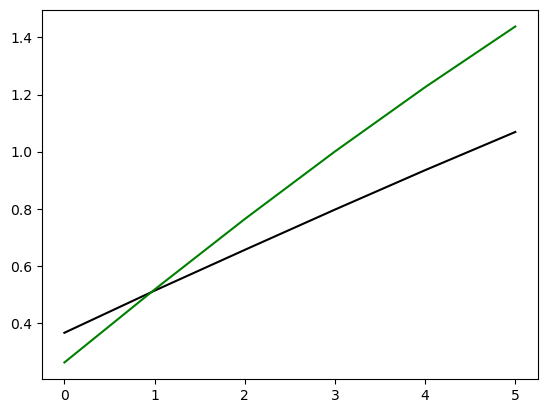

In [17]:
from matplotlib import pyplot as plt
from matplotlib import cm

# Plot rmse

plt.plot(rmse, '-k')
plt.plot(rmse_per, '-g')
plt.show()

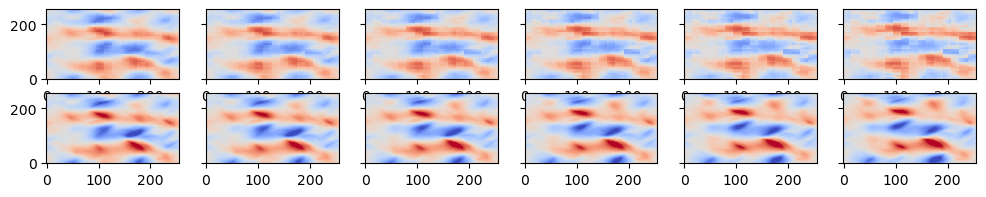

In [20]:
# Plot single instance of prediction and target

nplot = 6
fig, ax = plt.subplots(figsize=[12,2], nrows=2, ncols=nplot, sharey=True)
axs = ax.flatten()
preds = pred.squeeze(dim=2)
tars = target.squeeze(dim=2)
xx, yy = np.meshgrid(np.arange(preds.shape[-2]), np.arange(preds.shape[-1]))
for i in range(nplot):
    axs[i].pcolor(xx, yy, preds[i][1], cmap=cm.coolwarm, linewidth=0, antialiased=False, vmin=-5, vmax=5)
for i, step in enumerate(range(nplot, 2*nplot)):
    axs[step].pcolor(xx, yy, tars[i][1], cmap=cm.coolwarm, linewidth=0, antialiased=False, vmin=-5, vmax=5)
#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [19]:
params

{'gpu': True,
 'lr': 0.0002,
 'weight_decay': 0.01,
 'max_epochs': 5,
 'data_dir': '/ocean/projects/phy220045p/jakhar/py2d_dealias/results/Re5000_fkx4fky4_r0.1_b20.0/NoSGS/NX256/dt0.0002_IC1/data/',
 'train_file_range': (200000, 220000),
 'valid_file_range': (310000, 312000),
 'batch_size': 64,
 'num_workers': 1,
 'pin_memory': True,
 'img_size': 256,
 'patch_size': 16,
 'num_frames': 1,
 'tubelet_size': 1,
 'in_chans': 2,
 'encoder_embed_dim': 384,
 'encoder_depth': 12,
 'encoder_num_heads': 6,
 'decoder_embed_dim': 384,
 'decoder_depth': 12,
 'decoder_num_heads': 6,
 'mlp_ratio': 4.0,
 'norm_layer': torch.nn.modules.normalization.LayerNorm,
 'num_out_frames': 1,
 'log_to_screen': True,
 'logfile_path': '/ocean/projects/atm170004p/dpatel9/Logfiles/test1.log',
 'save_model': True,
 'model_save_dir': '/ocean/projects/atm170004p/dpatel9/ML_Weights/Base_Emulator/',
 'model_save_name': 'test1.pt',
 'params_save_name': 'test1_parameters.pkl'}